# WEAT
---

영화 시놉시스 코퍼스를 이용하여 Word Embedding을 구축한 후, WEAT score를 측정하여보자. 

## Step 0. 설계
---

1. Word Embedding 구축
    - 데이터 불러오기
    - 토큰화 : 형태소 분석기를 이용하여 품사가 명사인 단어만을 추출하여 말뭉치를 만든다.
    - Word2Vec 훈련
2. target, attribute 단어셋 만들기
    - target/attribute 데이터의 TF-IDF를 구하여 각 데이터 별로 중요단어 15개를 선정한다.
3. WEAT Socre 측정
    - 3에서 선정된 단어셋에 대하여 WEAT Score를 계산한다.

#### Environment Setting

In [1]:
from gensim.models import Word2Vec
from konlpy.tag import Okt

import matplotlib as mpl 
import matplotlib.pyplot as plt

import numpy as np
from numpy import dot
from numpy.linalg import norm

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import os

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




## Step 1. Word Embedding 구축
---

### 1. 데이터 불러오기

In [7]:
synopsis_path = os.getenv('HOME')+'/workspace/aiffel-gd-nlp/GD06_WEAT/data/synopsis/synopsis.txt'

with open(synopsis_path, 'r') as file:
    for i in range(10):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


### 2. 토큰화

In [5]:
okt = Okt()
tokenized = []

with open(synopsis_path, 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0])    
        tokenized.append(res)

In [6]:
print(len(tokenized))

71156


### 3. Word2Vec 훈련

#### 1) Word2Vec 모델 훈련
- 위에서 추출한 결과를 이용하여 Word2Vec 모델을 훈련 시킨다.

In [7]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[('작품', 0.8818110227584839),
 ('다큐멘터리', 0.8405174612998962),
 ('드라마', 0.8194983005523682),
 ('코미디', 0.7977256774902344),
 ('영화로', 0.7942900061607361),
 ('형식', 0.7832685112953186),
 ('주제', 0.7758829593658447),
 ('감동', 0.7720778584480286),
 ('스토리', 0.771220862865448),
 ('소재', 0.76994389295578)]

In [18]:
model.wv.most_similar(positive=['사랑'])

[('만남', 0.7230604887008667),
 ('이별', 0.6978504657745361),
 ('행복', 0.6970791220664978),
 ('연애', 0.6941631436347961),
 ('애정', 0.6937086582183838),
 ('첫사랑', 0.6934034824371338),
 ('진심', 0.6905822157859802),
 ('가슴', 0.6899749636650085),
 ('운명', 0.6864806413650513),
 ('토마슈', 0.686039924621582)]

In [19]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.9099433422088623),
 ('아티스트', 0.8847795724868774),
 ('데뷔', 0.8817678689956665),
 ('예술가', 0.8810724020004272),
 ('미술', 0.8767175674438477),
 ('영감', 0.8744353652000427),
 ('배우', 0.8717886805534363),
 ('예술', 0.865924060344696),
 ('오페라', 0.8644658327102661),
 ('영화로', 0.862600564956665)]

In [20]:
model.wv.most_similar(positive=['비극'])

[('극적', 0.8854536414146423),
 ('결말', 0.8440638184547424),
 ('동시', 0.8376821279525757),
 ('딜레마', 0.8311975002288818),
 ('광기', 0.8277866840362549),
 ('가해자', 0.8141322135925293),
 ('침묵', 0.8105169534683228),
 ('전개', 0.808942437171936),
 ('소용돌이', 0.8085982203483582),
 ('반전', 0.8048672080039978)]

#### 2) 모델 저장 및 불러오기
- 모델 재사용을 위하여 모델을 저장하고 이를 불러와 사용한다.

In [4]:
model_path = os.getenv('HOME')+'/workspace/aiffel-gd-nlp/GD06_WEAT/model/w2v.model'

In [34]:
# 모델 저장
model.save(model_path) # 모델 저장

In [35]:
!ls ./model

w2v.model


In [5]:
# 모델 불러오기
model = Word2Vec.load(model_path)
model.wv.most_similar(positive=['영화'])

[('작품', 0.8818110227584839),
 ('다큐멘터리', 0.8405174612998962),
 ('드라마', 0.8194983005523682),
 ('코미디', 0.7977256774902344),
 ('영화로', 0.7942900061607361),
 ('형식', 0.7832685112953186),
 ('주제', 0.7758829593658447),
 ('감동', 0.7720778584480286),
 ('스토리', 0.771220862865448),
 ('소재', 0.76994389295578)]

## Step 2. target, attribute 단어셋 만들기
---

WEAT score를 구할 단어 셋을 생성한다. <br>
이때, target는 영화 구분, attribute는 영화 장르로 둔다.
- target : 영화 구분(예술/일반)
- attribute : 영화 장르(SF/가족/공연/공포(호러)/기타/다큐멘터리/드라마/멜로로맨스/뮤지컬/미스터리/범죄/사극/서부극(웨스턴)/성인물(에로)/스릴러/애니메이션/액션/어드벤처/전쟁/코미디/판타지

각 단어 셋은 TF-IDF의 결과 가장 중요도가 높은 15개의 단어를 선정하여 구성한다.

### 1. Target

- 명사 추출

In [6]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'
data_dir_path = os.getenv('HOME')+'/workspace/aiffel-gd-nlp/GD06_WEAT/data/synopsis/'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(data_dir_path + file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [7]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


- 데이터를 TF-IDF로 표현

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [9]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [10]:
print(vectorizer.vocabulary_['사랑'])
print(vectorizer.get_feature_names()[16220])

16220
사랑


In [11]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

- 중복 제거

단어의 중복을 제거하고 TF-IDF가 높은 상위 15개를 추출한다.<br>
이때, 중복을 제거 한다는 것은 예술영화를 대표하는 단어는 일반영화를 대표하는 단어에 포함되지 않도록 한다는 의미를 가진다.

In [12]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [13]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [14]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


- 시각화

In [42]:
def show_pca(model, A_label, B_label, A_name, B_name): 
    A = np.array([model.wv[label] for label in A_label])
    B = np.array([model.wv[label] for label in B_label])
    
    pca = PCA(n_components=2)
    pc_A = pca.fit_transform(A)
    pc_B = pca.fit_transform(B)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(pc_A[:,0], pc_A[:,1], c='blue', label=A_name)
    ax.scatter(pc_B[:,0], pc_B[:,1], c='red', label=B_name)
    ax.legend()
    
    # annotation
    plt.rc('font', family='Noto Sans CJK JP')
    for i, label in enumerate(A_label):
        ax.annotate(label, (pc_A[:,0][i]+0.2, pc_A[:,1][i]))
        
    for i, label in enumerate(B_label):
        ax.annotate(label, (pc_B[:,0][i]+0.2, pc_B[:,1][i]))
    
    plt.show()

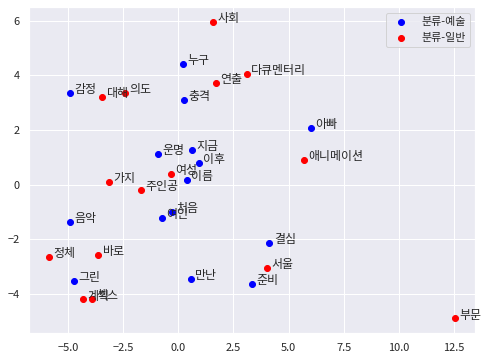

In [43]:
show_pca(model, target_art, target_gen, "분류-예술", "분류-일반")

두 영화를 분류를 대표하는 단어들의 위치가 그렇게 크게 갈리지 않음을 확인할 수 있다.

### 2. Attribute

- 명상 추출

In [17]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [18]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


- 데이터를 TF-IDF로 표현

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [20]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 20):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 통해, 그녀, 여성, 가족, 한국, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 카르피, 시작, 제루샤, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 아이, 민혁, 사실, 의문, 미스터리, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 수사, 발견, 한길수, 범인, 계획, 
사극: 조

In [21]:
def show_pca(model, words, labels): 
    def get_cmap(n, name='hsv'):
        return plt.cm.get_cmap(name, n)

    values = [ np.array([model.wv[w] for w in ws]) for ws in words ]
    
    pca = PCA(n_components=2)
    pc_res = [ pca.fit_transform(value) for value in values ]
    
    fig, ax = plt.subplots(figsize=(10, 7))
    cmap = get_cmap(len(words), 'jet')
    for i, pc_cur in enumerate(pc_res):
        ax.scatter(pc_cur[:,0], 
                   pc_cur[:,1], 
                   c=np.array([cmap(i)]), 
                   label=labels[i])
    
    plt.rc('font', family='Noto Sans CJK JP')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

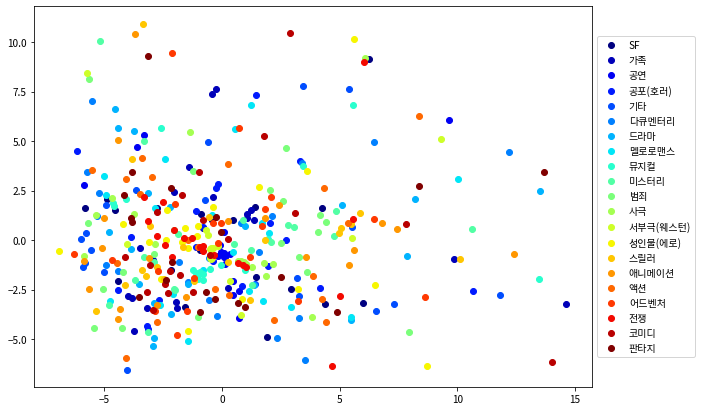

In [22]:
show_pca(model, attributes, genre_name)

## Step 3. WEAT Score 측정
---

target_A는 예술영화, target_B는 일반영화로 고정하고 attribute를 전체 장르로하여  WEAT Score를 계산해 보자.

### 1. WEAT Score 계산 함수 정의

In [23]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

### 2. WEAT Score 계산

In [24]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
np.array(matrix).shape

(21, 21)

In [25]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)
        matrix[j][i] = matrix[i][j]  * -1

### 3. 계산 결과 확인

- WEAT Score 해석
    - 변수
        - 두 타겟 X, Y
        - 두 타겟에서 분포의 편향성을 확인하고자 하는 두 특징(attibute) A, B
    - 코사인 유사도(cosine similarity)
        - 두 단에 벡터 a와 b 사이의 코사인 유사도는 두 단어 사이의 의미론적 유사도를 나타낸다.
        - $$cos(\theta) = \frac{a\cdot b}{||a||||b||}$$
        - 코사인 유사도는 -1에서 1 사이의 값을 가지면 1에 가까운수록 유사도가 높다고 말할 수 있다.
    - $s(w, A, B)$
        - $$s(w, A, B) = {\rm{mean}_{\it a \in A}cos(\it\overrightarrow{w}, \overrightarrow{a}) - \rm{mean}_{\it b \in B}{cos(\it\overrightarrow{w}, \overrightarrow{b})}}$$
        - 타겟의 단어($w$)와 A, B에 등장하는 단어들과의 유사도의 평균의 차이
        - 타겟의 단어($w$)가 A, B 중 어느 쪽으로 의미론적으로 더 가까운지/A-B에 대해 가지는 편향성을 계산한 것
        - 양의 뱡향으로 클수록 $w$는 A에 가깝고, 음의 방향으로 클수록 B에 가깝다.
    - WEAT Score
        - 타겟 데이터셋 X, Y상에 내포된 특징 A, B에 대한 편향성 점수
        - $$\frac{\rm{mean}_{\it x \in X}s(x,A, B) - \rm{mean}_{\it y \in Y}s(y,A, B)}{\rm{std}_{\it w \in X \cup Y}s(w, A, B)}$$
        - 분모가 타겟(X, Y)에 포함되는 모든 단어에 대한 유사도 차이의 표준편차이므로 이를 통하여 분자의 값을 정규화하는 효과르 가진다.
        - 분자 부분은 타겟(X, Y)에 속하는 각 단어  𝑥 ,  𝑦 들이 A, B에 대해 가지는 편향성을 다시 평균 내서 뺀 차이이다. 즉, X에 속하는 단어들과 Y에 속하는 단어들이 A, B에 대해 가지는 편향성의 정도가 뚜렷이 차이 날수록 이 WEAT score 식의 분자값의 절댓값은 커지게 된다. 
       - 경우를 나누어 생각해 본다면,
           - X가 A에 대한 편향성이 높고 Y가 B에 대한 편향성이 높다면, WEAT score는 양수 값을 가지게 되고 이는 편향성이 클수록 커지게 된다.
           - X가 A에 대한 편향성이 높고 Y도 A에 대한 편향성이 높다면, WEAT score는 0에 가까운 값을 가지게 되고 이는 둘이 가지는 편향성이 비슷할수록 0에 근사할 것이다.
           - X가 B에 대한 편향성이 높고 Y가 A에 대한 편향성이 높다면, WEAT score는 음수 값을 가지게 되고 이는 편향성이 클수록 커지게 된다.

- WEAT score 점수 확인

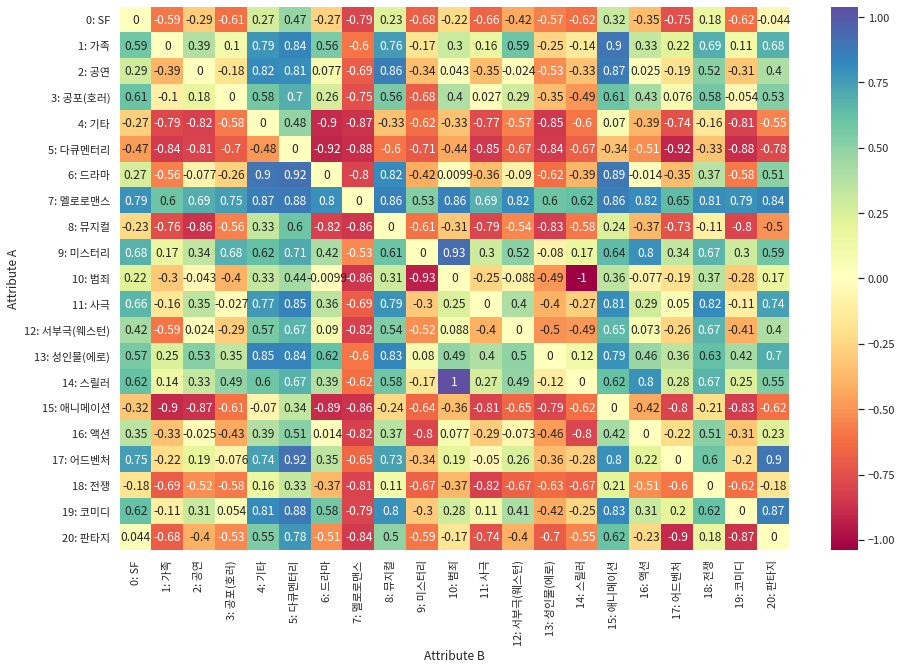

In [50]:
np.random.seed(0)
sns.set(font="Noto Sans CJK JP")

genre_name = [f'{i}: {name}' for i, name in enumerate(genre_name)]

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(matrix, 
                 xticklabels=genre_name, 
                 yticklabels=genre_name,
                 annot=True,
                 cmap='Spectral')
ax.set_ylabel('Attribute A')
ax.set_xlabel('Attribute B')
plt.show()

히트맵으로 살펴본 결과 값들이 -1~1 사이로 분포하며 편향성이 그렇게 많이 높지는 않은 것으로 보인다.<br>
걔중에 높은 수치를 보이는 절대값이 0.9 이상인 데이터들의 조합에 대하여 PCA를 적용하여 단어 분포를 확인해 보자.

- WEAT Score가 기준치(0.9) 이상이 데이터에 대한 벡터 시각화

In [47]:
def show_pca(X, Y, A, B): 
    pca = PCA(n_components=2)
    pc_A = pca.fit_transform(A)
    pc_B = pca.fit_transform(B)
    pc_X = pca.fit_transform(X)
    pc_Y = pca.fit_transform(Y)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
    ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
    ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
    ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')
    ax.legend()
    
    # annotation
    plt.rc('font', family='Noto Sans CJK JP')
    plt.show()

절대값이 0.9 이상으로 나온 것을 정리하면 다음과 같다.

In [62]:
for i in range(len(matrix)):
    for j in range(i+1, len(genre_name)):
        val = matrix[i][j]
        if val >= 0.9 or val <= -0.9:
            print(f'{genre_name[i]}, {genre_name[j]} : {val}')

5: 다큐멘터리, 6: 드라마 : -0.9153227806091309
5: 다큐멘터리, 17: 어드벤처 : -0.9164107441902161
9: 미스터리, 10: 범죄 : 0.9304545521736145
10: 범죄, 14: 스릴러 : -1.0395952463150024


- X: 예술영화, Y: 일반영화, A: 다큐멘터리, B: 드라마

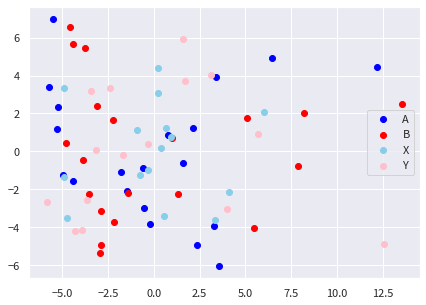

In [63]:
A = np.array([model.wv[label] for label in attributes[5]])
B = np.array([model.wv[label] for label in attributes[6]])
X = np.array([model.wv[label] for label in target_art])
Y = np.array([model.wv[label] for label in target_gen])
show_pca(X, Y, A, B)

- X: 예술영화, Y: 일반영화, A: 다큐멘터리, B: 어드벤처

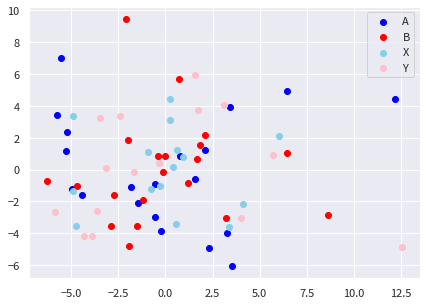

In [64]:
A = np.array([model.wv[label] for label in attributes[5]])
B = np.array([model.wv[label] for label in attributes[17]])
show_pca(X, Y, A, B)

- X: 예술영화, Y: 일반영화, A: 미스터리, B: 범죄

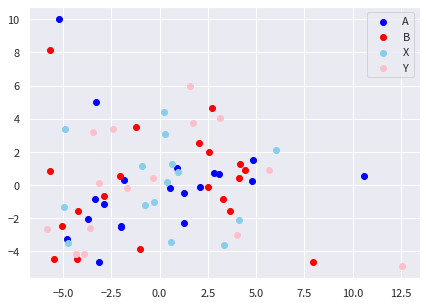

In [65]:
A = np.array([model.wv[label] for label in attributes[9]])
B = np.array([model.wv[label] for label in attributes[10]])
show_pca(X, Y, A, B)

- X: 예술영화, Y: 일반영화, A: 범죄, B: 스릴러

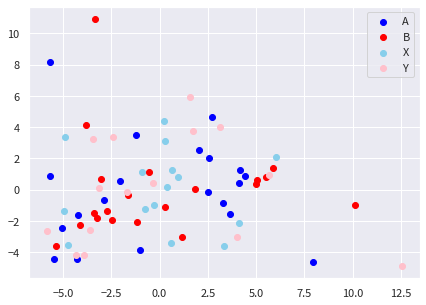

In [66]:
A = np.array([model.wv[label] for label in attributes[10]])
B = np.array([model.wv[label] for label in attributes[14]])
show_pca(X, Y, A, B)

WEAT Score 값이 양수인 경우에는 X-A, Y-B가 사이의 편향성이 높고, 음수인 경우에는 X-B, Y-A 사이의 편향성인 높다고  볼 수 있다. 즉 위의 경우 중 3번째인 [X: 예술영화, Y: 일반영화, A: 미스터리, B: 범죄]와 나머지 PCA의 결과가 반대로 나오는 것이 이상적이다. 하지만, 실제 결과로는 어떤 집단이 다른 집단과 긴밀하고 붙어있다고 말하기 애매할 정도로 벡터들이 산개되어 있다. WEAT Score 자체의 크기가 크지 않아 뚜렷한 구분을 만들어지지 않은 것으로 추정된다.

## STEP 4. 결론
---

### 1. 프로젝트 평가

1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다. <br>워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
    - 워드 임베딩 모델이 정상적으로 만들어졌다.
    - most_similar 함수의 출력 결과, 영화는 작품, 사랑의 경우는 만남, 연극의 경우는 영화감독, 비극의 경우는 극적이 유사한 단어가 나왔다. 의미상으로 올바르게 출력된 것으로 보인다.
2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.<br> 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
    - target에 대해서는 서로의 중복을 제거하여 주었고, attribute에 대해는 중복률이 낮아 중복 제거를 시도하지 않았다.
    - 대표성 있는 단어셋이 생성되었다.
        -  SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선
3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.<br>전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다. 
    - WEAT socre를 계산이 정상적으로 수행되었고 히트맵으로 점수를 시각화 하였다.
    - WEAT score로 미두러 보았을 때, 예술영화에 가까운 장르는 다큐멘터라, 미스터리, 범죄물이고 일반 상업 영화와 가까운 장르는 드라마, 어드벤쳐, 범죄, 스릴러물이다. 범죄라는 공통적은 장르를 제외한다면 상식의 선에게 납득할 수 있는 분류이다.

### 2. 논의사항
- WEAT Score는 어디에 사용될 수 있을까?
    - 생각해본바로는 WEAT Score는 두가지 측면에서 사용이 가능할 것 같다.
    - 먼저, EDA 과정에서 데이터의 특성을 분석할 때 사용할 수 있을 것이다. 이 과정에서 학습용 말뭉치의 특성을 파악하고 혹시 있을 수 있는 밸런스가 맞지 않는 경우에 대한 처리가 가능할 것이다.
    - 모델의 예측 결과를 해석하는데 사용이 가능할 것이다. 모델의 예측 결과가 사전에 예상에 것과 다를 때 그 원인을 분석하는 하나의 지표로 사용 될 수 있다 생각된다.
- TF-IDF 이대로 괜찮은가?
    - TF-IDF를 기준으로 하여 문서별 주요 단어를 출력하였을 때, 문서간에 중복되는 단어가 다수 발견 되었다. 즉, 해당 단어셋이 문서를 대표하는 유니크한 단어셋이라고 말하기 애매한 상황이 발생한 것이다.
    - TF-IDF는 대상 문서가 아닌 다른 문서에도 자주 출몰하는 다빈도 단어에 대한 필터링을 진행하여 주는 것이 장점이다. 이번 경우에는 이 장점이 제대로 발휘되지 못하였는데 추측컨데 시놉시스라는 동일한 장르의 문서들을 대상으로 연산이 진행되서가 아닐까 싶다. 스놉시스는 줄거리에 대한 짧고 강렬한 글로 어쩔 수 없이 '그', '그녀' 등의 단어들이 IDF를 반영하여도 대표단어로 튀어 나오는 것을 피할 수 없을 것이다.
    - 이를 보완하기 위한 몇가지 방안을 생각해 볼 수 있다. 먼저 전체 문서들을 통틀어 그 크기가 100 정도가 되는 단어사전(등장 빈도가 높은 상위 100개 유지)를 생성한다. 그 후 문서들을 다시 읽어 개별 토큰화를 진행할 때 구축된 단어사전을 stop word로 사용하여 자주 등장하는 단어를 아예 제거한채로 TF-IDF를 구할 수도 있을 것이다. 다른 방법으로는 TF-IDF가 아닌 다른 방식을 이용하여 문서의 주요 단어를 도출하는 것이 있다. 한 예로는 subword 기반으로 문서의 키워드를 추출하는 [KRWordRank](https://github.com/lovit/kr-wordrank)가 있다.

### 3. 회고
- WEAT Score에 대한 정보가 생각보다 찾기가 어려워서 조금 힘든감이 있었다.
- 온라인 상으로 게시된 자료를 찾기 힘들어 스스로 생각해야하는 부분이 많았어서 흥미진진하게 프로젝트를 진행할 수 있었다.

## ref
---

- [Text Embedding Models Contain Bias. Here's Why That Matters.](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html)
- [03) 영어/한국어 Word2Vec 실습](https://wikidocs.net/50739)
- [Word2Vec - 시각화(t-SNE, PCA)](https://joyhong.tistory.com/133)
 - [알고리즘·데이터 이용에 따른 이용자 행태 변화 분석에 관한 연구](http://kisdi.kr/kisdi/fp/kr/publication/selectResearch.do?cmd=fpSelectResearch&sMenuType=3&controlNoSer=4&controlNo=14815&langdiv=1)
 - [1) 코사인 유사도(Cosine Similarity)](https://wikidocs.net/24603)
 - [KR-WordRank 를 이용한 핵심 문장 추출과 ROUGE 를 이용한 요약문 성능 평가](https://lovit.github.io/nlp/2019/05/01/krwordrank_sentence/)
 - [Semantics derived automatically from language corpora contain human-like biases
](https://arxiv.org/abs/1608.07187)